In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from spacy.lang.nl.examples import sentences 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import spacy
import itertools
from collections import Counter
import nltk
import tikzplotlib

In [2]:
#synsets
syns_homo = ['homoseksuele', 'gay', 'flikker','homo', 'homofiel', 'homoseksueel']
syns_neger = ['moor', 'neger', 'negerin'] 
syns_zigeuner = ['roma', 'zigeunerin', 'gipsy', 'zigeuner']
synsets = syns_zigeuner + syns_homo +s yns_neger

In [3]:
#read all data
all_df = pd.read_csv('all_df_2607.csv')
no_ads = pd.read_csv('no_ads_2607.csv')

total_numbers = pd.read_csv('total_number_articles.csv')
total_na_numbers = pd.read_csv('na_number_articles.csv')

In [4]:
#get total results
total_numbers = total_numbers[['decade','total_results']].groupby('decade').agg('sum').reset_index()
na_numbers = total_na_numbers[['decade','total_results']].groupby('decade').agg('sum').reset_index()

In [5]:
all_df = all_df.drop_duplicates('text')
all_df_merged = all_df.merge(total_numbers,left_on=['decade'],right_on=['decade'], how='left')

no_ads = no_ads.drop_duplicates('text')
na_df_merged = no_ads.merge(na_numbers,left_on=['decade'],right_on=['decade'], how='left')

In [6]:
grouped_df = all_df_merged[['decade','article_id','search_term']].groupby(['decade','search_term']).agg('count')
grouped_df = grouped_df.reset_index()
grouped_df.columns=['decade','search_term','num_occurrences']
grouped_df

na_grouped_df = na_df_merged[['decade','article_id','search_term']].groupby(['decade','search_term']).agg('count')
na_grouped_df = na_grouped_df.reset_index()
na_grouped_df.columns=['decade','search_term','num_occurrences']
na_grouped_df

,decade,search_term,num_occurrences
0,1940,flikker,3
1,1940,gay,85
2,1940,gipsy,17
3,1940,homo,69
4,1940,moor,365
...,...,...,...
69,1990,neger,766
70,1990,negerin,90
71,1990,roma,4062
72,1990,zigeuner,387


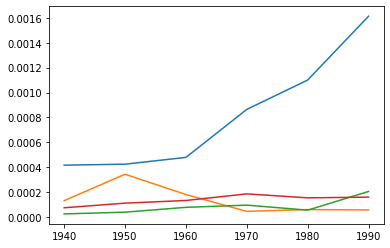

In [7]:
grouped_with_total = grouped_df.merge(all_df_merged[['decade','search_term','total_results']],on=['decade','search_term'])
grouped_with_total['rel_prev'] = grouped_with_total['num_occurrences']/grouped_with_total['total_results']


na_grouped_with_total = na_grouped_df.merge(na_df_merged[['decade','search_term','total_results']],on=['decade','search_term'])
na_grouped_with_total['rel_prev'] = na_grouped_with_total['num_occurrences']/na_grouped_with_total['total_results']

grouped_with_total.drop_duplicates(inplace=True)
na_grouped_with_total.drop_duplicates(inplace=True)

all_traces = {}
na_all_traces = {}

for i in synsets:
    x = [1940,1950,1960,1970,1980,1990]
    for word in i:
        y = {}
        z = grouped_with_total.loc[grouped_with_total['search_term'] == word][['decade','rel_prev']]
        k = {}
        l = na_grouped_with_total.loc[na_grouped_with_total['search_term'] == word][['decade','rel_prev']]

        for i in x:
            if i in list(z['decade']):
                y[i] = z.loc[z['decade'] == i]['rel_prev'].item()
                k[i] = l.loc[l['decade'] == i]['rel_prev'].item()
            else:
                y[i] = 0
                k[i] = 0
        all_traces[word] = y
        na_all_traces[word] = k
        plt.plot(x,list(y.values()))


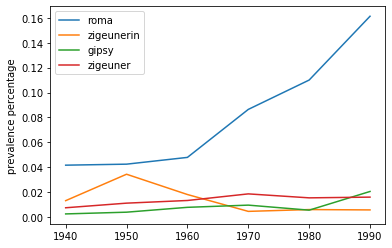

In [8]:
fig, ax = plt.subplots()
for i in syns_zigeuner:
    if i in list(na_all_traces.keys()):
        plt.plot(x,[i*100 for i in list(all_traces[i].values())],label = i)
        plt.legend(loc="upper left")
plt.ylabel("prevalence percentage")       
fig.savefig('prev_2607_zigeuner.pdf')

## Context words

In [9]:
#initialize nlp function
nlp = spacy.load("nl_core_news_sm")
raw_texts =  list(all_df['text'])

In [10]:
def get_bigrams(texts,search_term):
    texts = [text.replace("\\n", "").strip().lower() for text in texts]
    texts = [text.replace("\\", "").strip() for text in texts]
    texts = [''.join([c for c in text if c.isalnum() or c == ' ']) for text in texts]
    stopwords_list = list(stopwords.words('dutch'))
    bgs = nltk.bigrams(str(texts).split())

    fdist = nltk.FreqDist(bgs)
    sorted_fdist = dict(sorted(fdist.items(), key=lambda item: item[1],reverse=True))

    list_of_tuples = list(sorted_fdist.items())
    cleaned_tuples = [i for i in list_of_tuples if i[0][0] not in stopwords_list and i[0][1] not in stopwords_list 
                      and len(i[0][0]) > 2 and len(i[0][1]) > 2 
                      and search_term in i[0] and i[1] > 2]
    return cleaned_tuples

In [11]:
def bigrams_table_tex(df,word):
    decades = [1940,1950,1960,1970,1980,1990]
    bgs_df = pd.DataFrame()
    for decade in decades:
        bgs = get_bigrams(list(df.loc[(df['search_term'] == word) & (df['decade'] == decade)]['text']),word)
    #     fig, ax = plt.subplots()
        top10 = [str(i)[1:-1] for i in bgs[:10]]
        if len(top10) == 10:
            bgs_df[decade] = top10
        else:
            bgs_df[decade] = top10 + ["-"] * (10-len(top10))
    #print(bgs_df.to_latex())
    return bgs_df

In [19]:
for i in syns_zigeuner:
    with open(f'{i}_bigram_table.tex', 'w') as tf:
        tf.write(bigrams_table_tex(all_df,i))

In [20]:
for i in syns_zigeuner:
    with open(f'na_{i}_bigram_table.tex', 'w') as tf:
        tf.write(bigrams_table_tex(no_ads,i))